## STAC OWSLib Interoperability Demo

Goal: Show that open source OGC clients can be used to perform meaningful queries on GeoAnalytics STAC API

### About OWSLib

>OWSLib is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models. 

https://geopython.github.io/OWSLib

In [1]:
import os

import pandas as pd
import yaml
from owslib.ogcapi.features import Features

In [2]:
with open('./config.yml') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [3]:
STAC_URL = 'https://stac.geoanalytics.ca'
AUTH_TOKEN = config['AUTH_TOKEN']

In [4]:
headers = {'cookie': f'_oauth2_proxy={AUTH_TOKEN}'}
stac = Features(STAC_URL, headers=headers)

In [5]:
def format_time_query(start, end):
    if (start is None) or (start == ''):
        start = '..'
    if (end is None) or (end == ''):
        end = '..'
    return f'{start}/{end}'

In [6]:
def format_property_query(key, val, op='='):
    return f'{key}{op}{val}'

In [7]:
def summarize_response(res):
    if (not res['type']):
        print(f'unexpected result {res}')
    features = res['features']
    count = len(features)
    rows = [extract_row(x) for x in features]
    df = pd.DataFrame(rows)
    first = df['datetime'].min()
    last = df['datetime'].max()
    print(f'Query returned {count} points from {first} to {last}')
    return df

def extract_row(row):
    return {
        'id': row['id'],
        'datetime': row['properties'] and row['properties']['datetime'],
        'day_night_flag': row['properties'] and row['properties']['modis:day_night_flag'],
        'link': row['assets']['data']['href']
    }

## Input parameters for STAC query

In [8]:
# define query variables
evi2_collection = 'modis.mod09gq.veg.evi2'
bbox_input = [-80, 42, -75, 47]


In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def bbox_to_xy(bbox):
    return [bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]],\
        [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]]

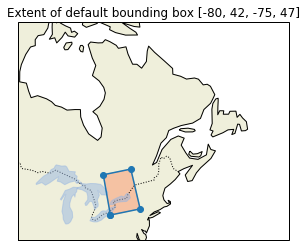

In [10]:
fig = plt.figure()
proj = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
ax.set_extent([-95, -50, 60, 40], crs=proj)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAKES, alpha=0.5)

x, y = bbox_to_xy(bbox_input)
#ax.plot(-105, 60, marker='o', transform=proj)
ax.plot(x,y, marker='o', transform=proj)
ax.fill(x, y, color='coral', alpha=0.4, transform=proj)
ax.set_title(f'Extent of default bounding box {bbox_input}')
plt.show()

### Query EVI2 data from 2015 to 2020 in Southern Quebec

In [11]:
# query by time, and bbox
time_start = '2015-01-01' 
time_end = ''
bbox = [str(x) for x in bbox_input]
datetime = format_time_query(time_start, time_end)


res = stac.collection_items(evi2_collection, bbox=bbox, datetime=datetime, limit=5000)
df = summarize_response(res)
df.head()

Query returned 1855 points from 2015-01-01T15:35:00Z to 2020-03-08T00:00:00Z


,id,datetime,day_night_flag,link
0,MOD09GQ.A2015001.h12v04.006.2015295022027_vegevi2,2015-01-01T15:35:00Z,BOTH,https://gp.geoanalytics.ca?object=modis-terra/...
1,MOD09GQ.A2015002.h12v04.006.2015295014944_vegevi2,2015-01-02T14:40:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
2,MOD09GQ.A2015003.h12v04.006.2015295033544_vegevi2,2015-01-03T15:20:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
3,MOD09GQ.A2015004.h12v04.006.2015295060515_vegevi2,2015-01-04T14:30:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
4,MOD09GQ.A2015005.h12v04.006.2015295070636_vegevi2,2015-01-05T15:10:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...


### Query EVI2 data from Jan to Dec 2019 in Southern Quebec

Querying by date range

In [12]:
# ex. change datetime range
time_start = '2019-01-01' 
time_end = '2019-12-01'
bbox = [str(x) for x in bbox_input]
datetime = format_time_query(time_start, time_end)


res = stac.collection_items(evi2_collection, bbox=bbox, datetime=datetime, limit=5000)
df = summarize_response(res)
df.head()

Query returned 335 points from 2019-01-01T15:50:00Z to 2019-12-01T00:00:00Z


,id,datetime,day_night_flag,link
0,MOD09GQ.A2019001.h12v04.006.2019003024848_vegevi2,2019-01-01T15:50:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
1,MOD09GQ.A2019002.h12v04.006.2019004032626_vegevi2,2019-01-02T15:00:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
2,MOD09GQ.A2019003.h12v04.006.2019005024751_vegevi2,2019-01-03T15:40:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
3,MOD09GQ.A2019004.h12v04.006.2019006025116_vegevi2,2019-01-04T14:45:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
4,MOD09GQ.A2019005.h12v04.006.2019007024826_vegevi2,2019-01-05T15:30:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...


### Query EVI2 data derived from daytime data from Jan to Jun 2019 in Southern Quebec

Querying by metadata properties

In [13]:
## define a property filter
#  ex. filter by day-night flag
prop = format_property_query('modis:day_night_flag', 'DAY')

In [14]:
# query by time, bbox, and day-night flag

res = stac.collection_items(evi2_collection, bbox=bbox, datetime=datetime, query=prop, limit=5000)
df = summarize_response(res)
df.head()

Query returned 332 points from 2019-01-01T15:50:00Z to 2019-11-30T00:00:00Z


,id,datetime,day_night_flag,link
0,MOD09GQ.A2019001.h12v04.006.2019003024848_vegevi2,2019-01-01T15:50:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
1,MOD09GQ.A2019002.h12v04.006.2019004032626_vegevi2,2019-01-02T15:00:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
2,MOD09GQ.A2019003.h12v04.006.2019005024751_vegevi2,2019-01-03T15:40:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
3,MOD09GQ.A2019004.h12v04.006.2019006025116_vegevi2,2019-01-04T14:45:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
4,MOD09GQ.A2019005.h12v04.006.2019007024826_vegevi2,2019-01-05T15:30:00Z,DAY,https://gp.geoanalytics.ca?object=modis-terra/...
